# VGG16, U-Net

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from data.dataloader import dataloader
from vgg.vgg16 import VGG16
from vgg.methods import training, evaluating
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.10.0+cu128
True
cuda


In [3]:
train_loader, test_loader, val_loader = dataloader('CIFAR10', batch_size=64, val_split=0.2)
classes_name = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

/home/aki/anaconda3/envs/fdaa/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


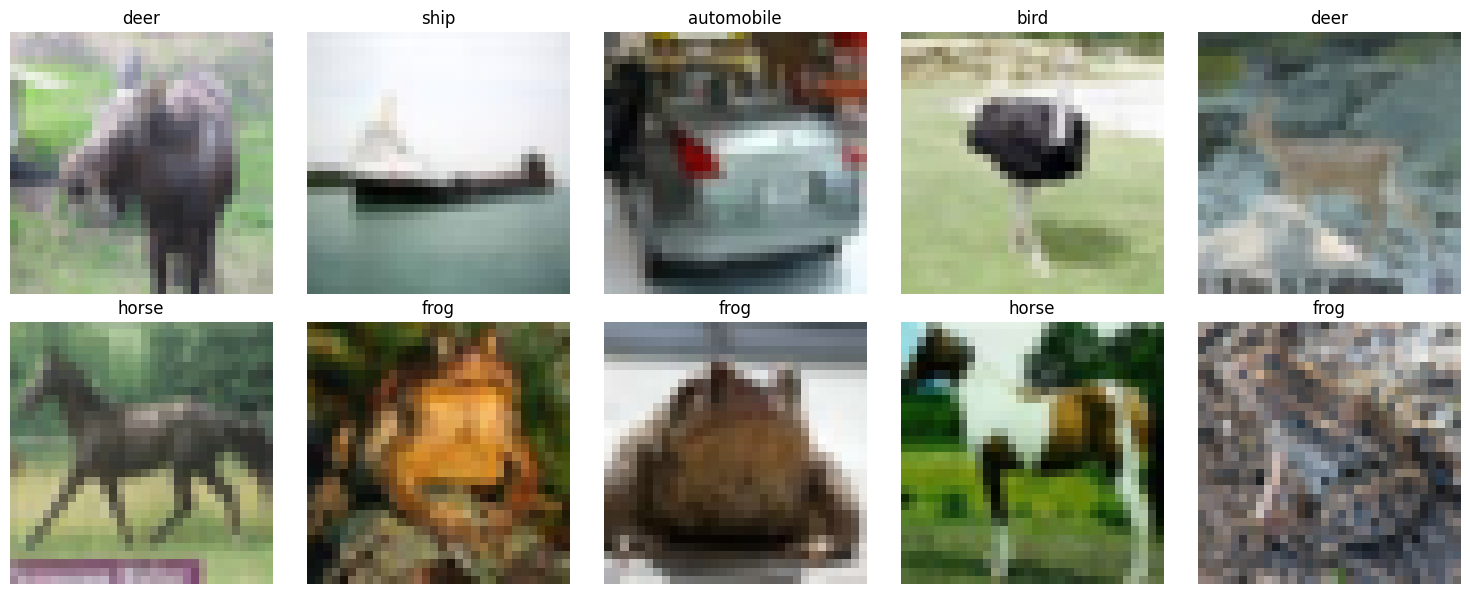

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for imgs, labels in train_loader:
    # Get images from train set
    img = imgs[:10]
    label = labels[:10]
    for i in range(10):
        img_test = img[i]
        name = classes_name[label[i].item()]

        # Normalize and transpose
        img_test = img_test * 0.5 + 0.5
        img_test = img_test.permute(1, 2, 0).cpu().numpy()

        # Plot the image
        axes[i].imshow(img_test)
        axes[i].set_title(name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    break


In [4]:
from torchinfo import summary
epochs = 10
lr = 0.1
criterion = CrossEntropyLoss()

model = VGG16(num_classes=10)
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─ConvBlock: 2-1                    [1, 64, 16, 16]           --
│    │    └─ModuleList: 3-1              --                        38,720
│    └─ConvBlock: 2-2                    [1, 128, 8, 8]            --
│    │    └─ModuleList: 3-2              --                        221,440
│    └─ConvBlock: 2-3                    [1, 256, 4, 4]            --
│    │    └─ModuleList: 3-3              --                        1,475,328
│    └─ConvBlock: 2-4                    [1, 512, 2, 2]            --
│    │    └─ModuleList: 3-4              --                        5,899,776
│    └─ConvBlock: 2-5                    [1, 512, 1, 1]            --
│    │    └─ModuleList: 3-5              --                        7,079,424
├─Sequential: 1-2                        [1, 10]       

Training Progress: 100%|██████████| 10/10 [04:21<00:00, 26.14s/it, train_loss=2.3, val_loss=2.3]


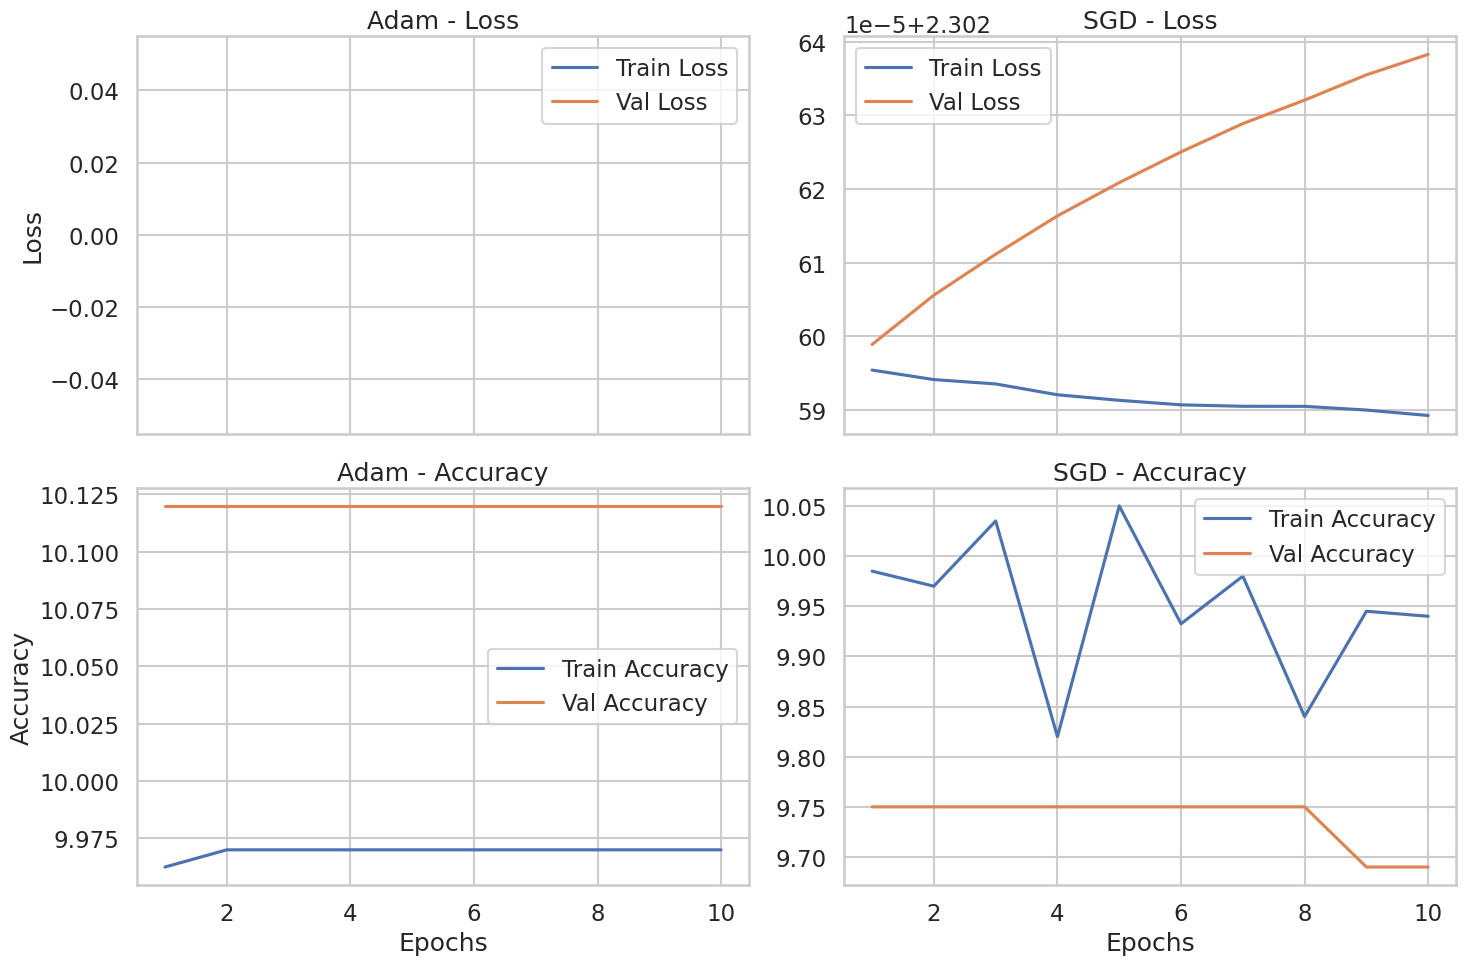

In [35]:
from utils import plot_metrics

modelAdam = VGG16(num_classes=10)
modelSGD = VGG16(num_classes=10)

optimizer2, optimizer1 = SGD(modelSGD.parameters(), lr=lr), Adam(modelAdam.parameters(), lr=lr)

train_losses, train_accuracies, val_losses, val_accuracies = training(
    modelAdam, train_loader, criterion, optimizer1, device, epochs, val_loader 
)

train_losses2, train_accuracies2, val_losses2, val_accuracies2 = training(
    modelSGD, train_loader, criterion, optimizer2, device, epochs, val_loader 
)

torch.save(modelSGD.state_dict(), 'vgg16_cifar10SGD.pth')
torch.save(modelAdam.state_dict(), 'vgg16_cifar10Adam.pth')

plot_metrics(
    train_losses, val_losses, train_accuracies, val_accuracies,
    train_losses2, val_losses2, train_accuracies2, val_accuracies2,
    epochs,
    opt1_name="Adam",
    opt2_name="SGD"
)

The model with an Adam algorithm does have a more stable accuracy during training and validation, without outperforming the second one with a SGD optimizer.
Moreover, the latter, has greater value of loss regarding the loss value obtained with the Adam' model.

Training Progress: 100%|██████████| 10/10 [04:20<00:00, 26.04s/it, train_loss=nan, val_loss=nan]


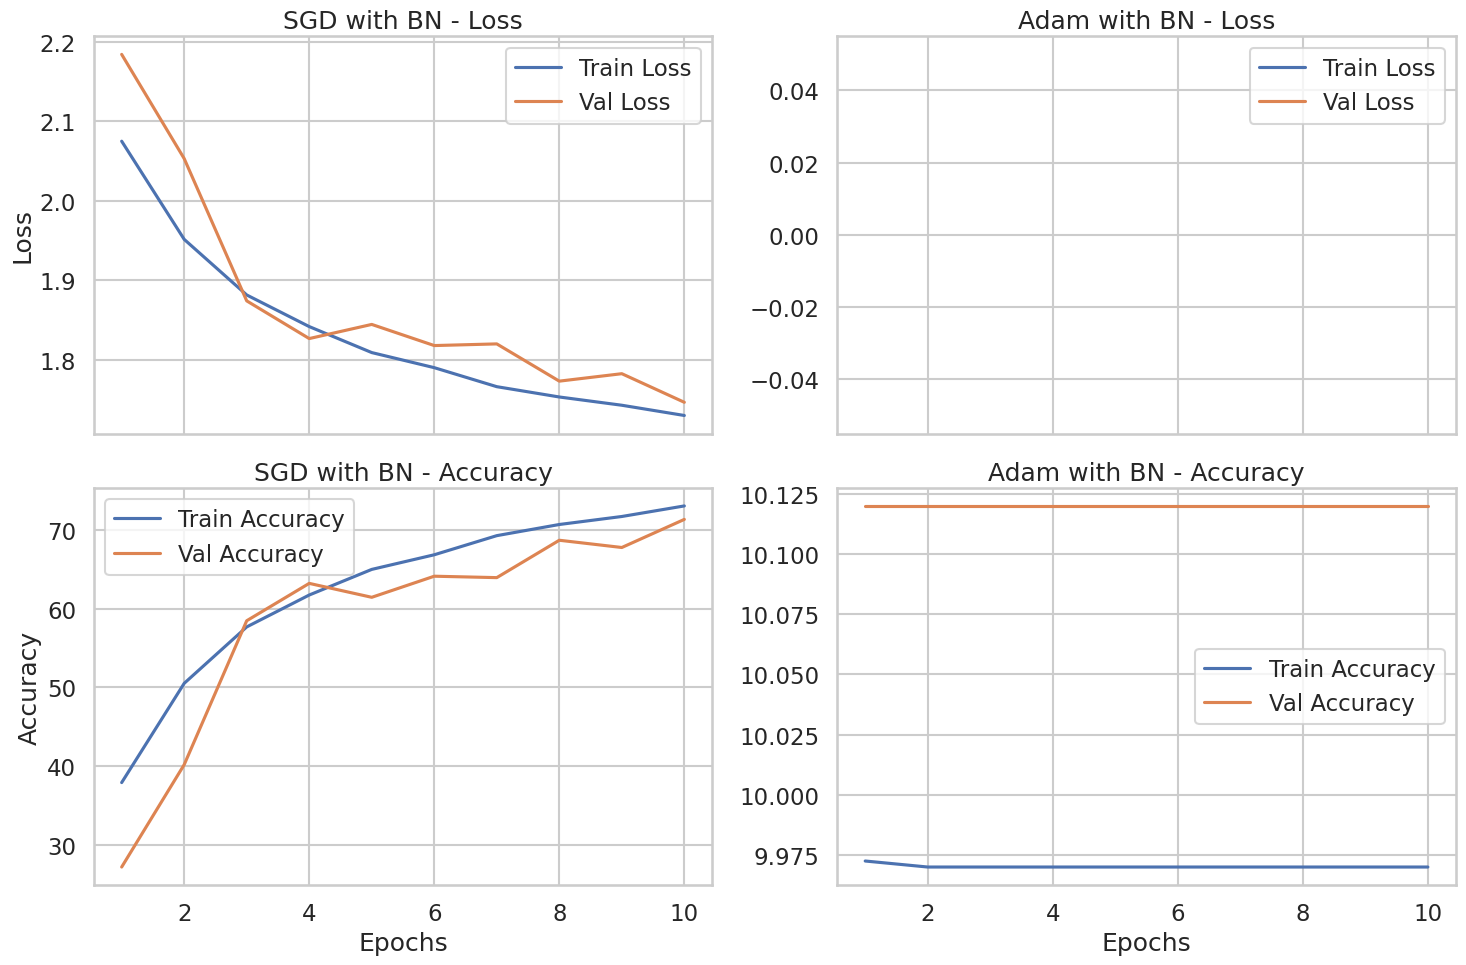

In [36]:
model2SGD = VGG16(num_classes=10, batch_normalization=True)
model2Adam = VGG16(num_classes=10, batch_normalization=True)
optimizer_model2_1, optimizer_model2_2 = SGD(model2SGD.parameters(), lr=lr), Adam(model2Adam.parameters(), lr=lr)

model2_train_loss, model2_train_acc, model2_val_loss, model2_val_acc = training(
    model2SGD, train_loader, criterion, optimizer_model2_1, device, epochs, val_loader 
)

model2_train_loss2, model2_train_acc2, model2_val_loss2, model2_val_acc2 = training(
    model2Adam, train_loader, criterion, optimizer_model2_2, device, epochs, val_loader 
)

torch.save(model2SGD.state_dict(), 'vgg16_bn_cifar10SGD.pth')
torch.save(model2Adam.state_dict(), 'vgg16_bn_cifar10Adam.pth')

plot_metrics(
    model2_train_loss, model2_val_loss, model2_train_acc, model2_val_acc,
    model2_train_loss2, model2_val_loss2, model2_train_acc2, model2_val_acc2,
    epochs,
    opt1_name="SGD with BN",
    opt2_name="Adam with BN"
)

It can be stated, that with batch normalization we obtain better performance for the SGD model for training as well as for validation unlike the Adam one.

Training Progress: 100%|██████████| 10/10 [06:29<00:00, 38.98s/it, train_loss=nan, val_loss=nan]


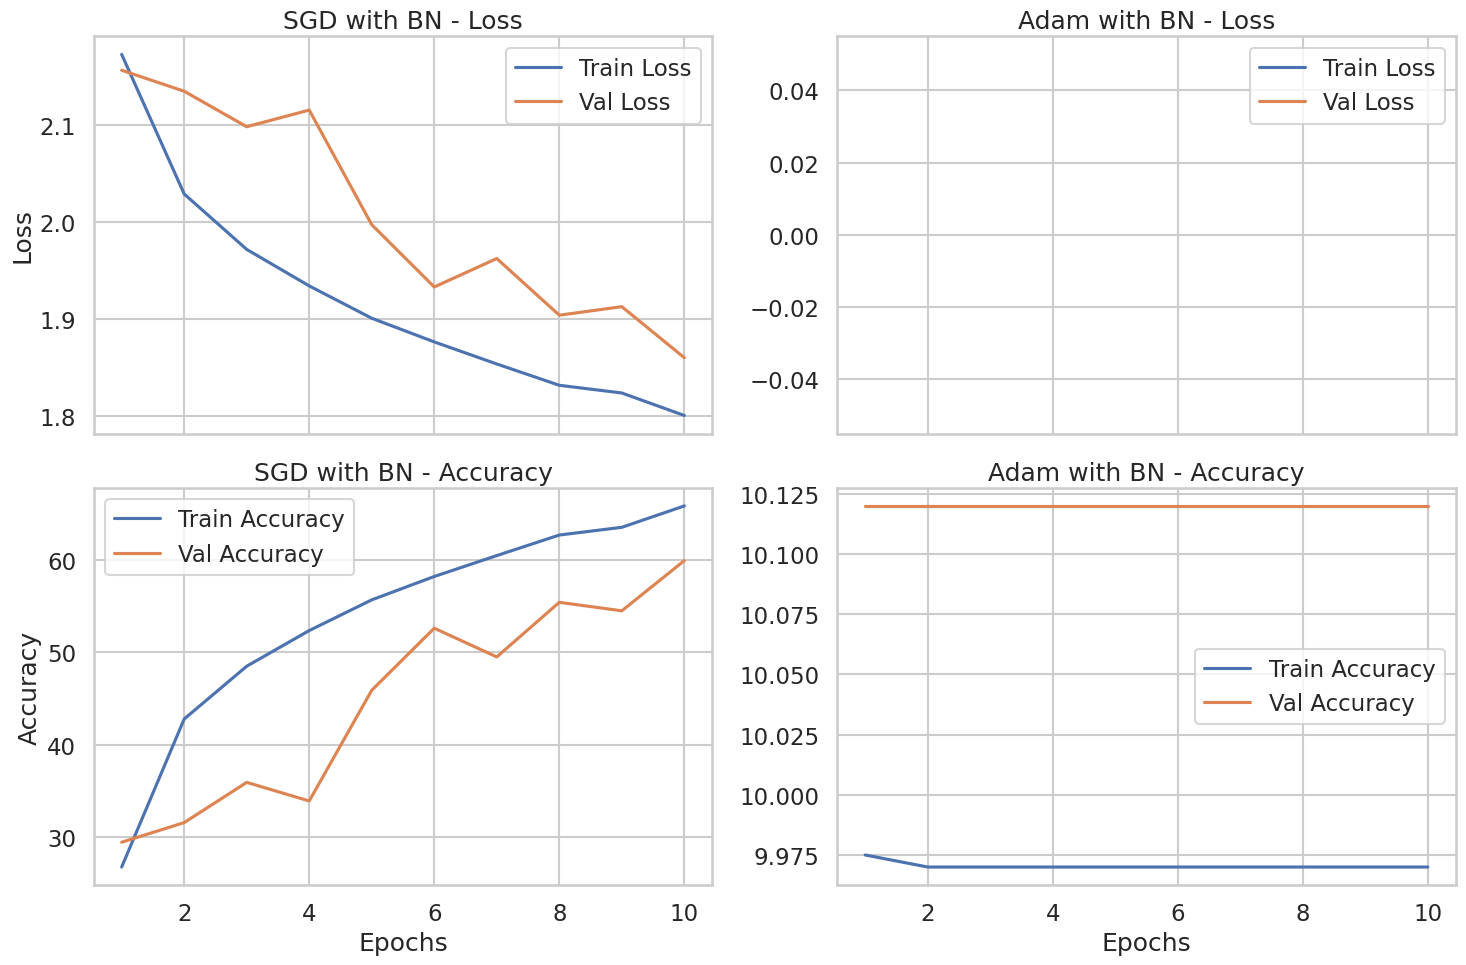

In [49]:
mode32GD = VGG16(num_classes=10, batch_normalization=True, dropout=0.2)
model3Adam = VGG16(num_classes=10, batch_normalization=True, dropout=0.2)
optimizer_model3_1, optimizer_model3_2 = SGD(mode32GD.parameters(), lr=lr), Adam(model3Adam.parameters(), lr=lr)

model3_train_loss, model3_train_acc, model3_val_loss, model3_val_acc = training(
    mode32GD, train_loader, criterion, optimizer_model3_1, device, epochs, val_loader 
)

model3_train_loss2, model3_train_acc2, model3_val_loss2, model3_val_acc2 = training(
    model3Adam, train_loader, criterion, optimizer_model3_2, device, epochs, val_loader 
)

torch.save(mode32GD.state_dict(), 'vgg16_dbn_cifar10SGD.pth')
torch.save(model3Adam.state_dict(), 'vgg16_dbn_cifar10Adam.pth')

plot_metrics(
    model3_train_loss, model3_val_loss, model3_train_acc, model3_val_acc,
    model3_train_loss2, model3_val_loss2, model3_train_acc2, model3_val_acc2,
    epochs,
    opt1_name="SGD with BN",
    opt2_name="Adam with BN"
)

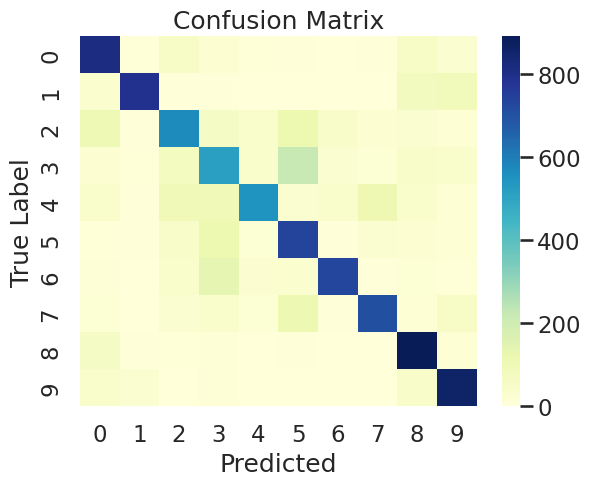

In [ ]:
from vgg.methods import prediction

best_model = model2SGD

all_preds, all_labels = prediction(best_model, test_loader, device, cm=True)

According to the confusion matrix, the model is mistaking frog (6th class) with cat (3rd class) and frog with dog (5th class). 

## Fine-Tuning

In [5]:
import torch.nn as nn
import torchvision.models as models

model = models.vgg16(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier to fit CIFAR-10
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)

summary(model, input_size=(1, 3, 32, 32))

/home/aki/anaconda3/envs/fdaa/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aki/anaconda3/envs/fdaa/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           (1,792)
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           (36,928)
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          (73,856)
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          (147,584)
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 128, 8, 8]            --
│    └─Conv2d: 2-11                      [1, 256, 8, 8]      

Training Progress: 100%|██████████| 15/15 [09:13<00:00, 36.89s/it, train_loss=8.47, val_loss=5.12]


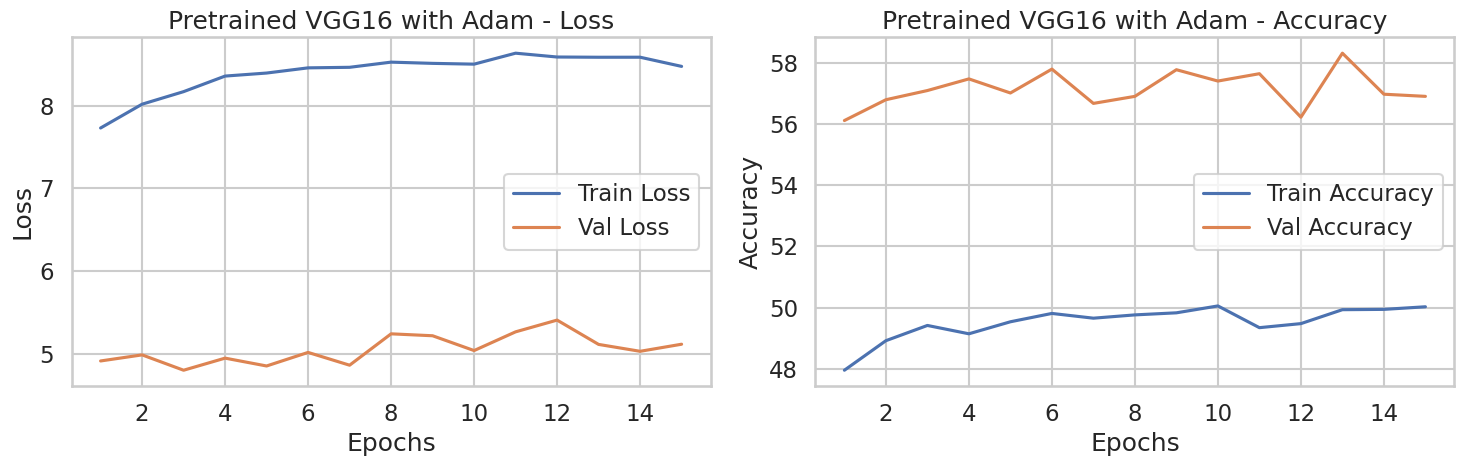

Training Progress: 100%|██████████| 100/100 [56:22<00:00, 33.82s/it, train_loss=1.44, val_loss=1.13]  


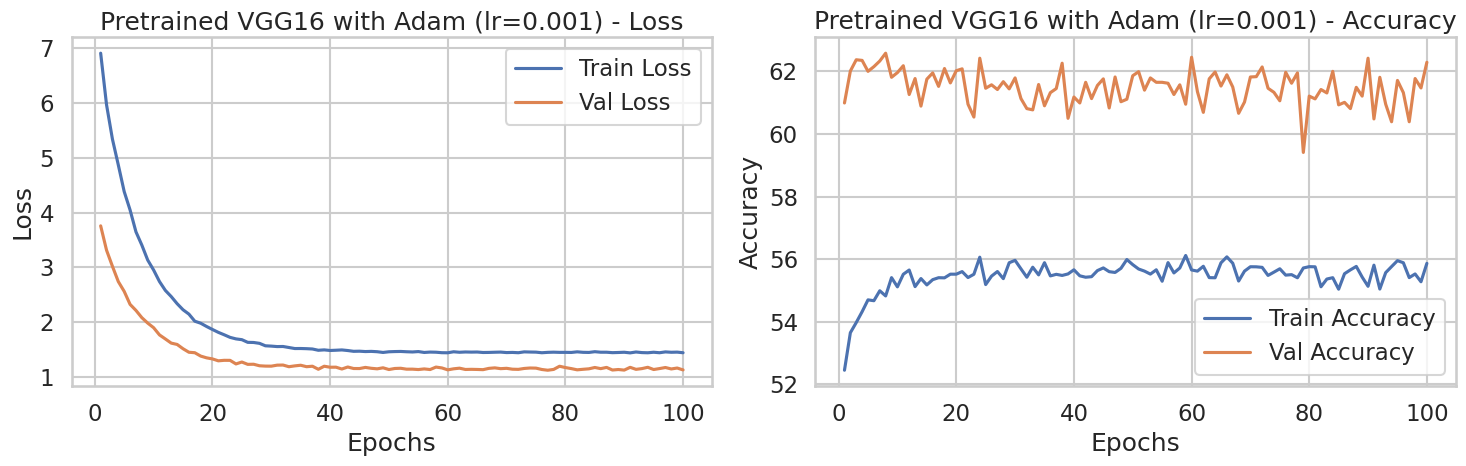

In [8]:
from utils import plot_metrics

optimizer = Adam(model.parameters(), lr=0.01)
train_losses, train_accuracies, val_losses, val_accuracies = training(
    model, train_loader, criterion, optimizer, device, 15, val_loader
)
plot_metrics(
    train_losses, val_losses, train_accuracies, val_accuracies,
    epochs=15,
    opt1_name="Pretrained VGG16 with Adam"
)

optimizer = Adam(model.parameters(), lr=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = training(
    model, train_loader, criterion, optimizer, device, 100, val_loader
)
plot_metrics(
    train_losses, val_losses, train_accuracies, val_accuracies,
    epochs=100,
    opt1_name="Pretrained VGG16 with Adam (lr=0.001)"
)

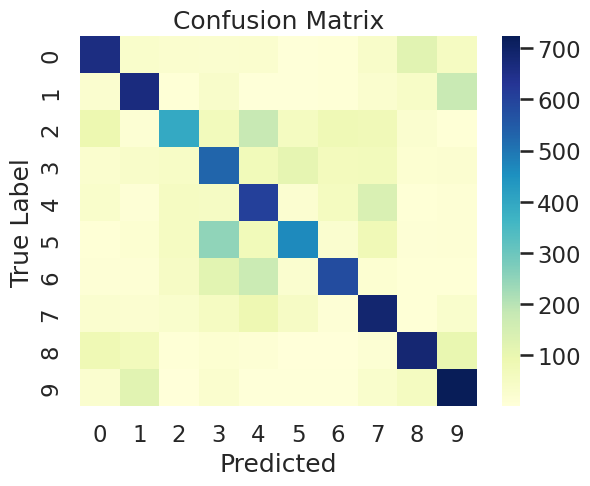

In [10]:
from vgg.methods import prediction

all_preds, all_labels = prediction(model, test_loader, device, cm=True)